## Tool Use with Anthropic API for structured outputs

Anthropic API recently added tool use.

This is very useful for structured output.

In [ ]:
! pip install -U langchain-anthropic

In [ ]:
# Optional
import os
# os.environ['LANGSMITH_TRACING'] = 'true' # enables tracing
# os.environ['LANGSMITH_API_KEY'] = <your-api-key>

`How can we use tools to produce structured output?`

Function call / tool use just generates a payload.

Payload often a JSON string, which can be pass to an API or, in this case, a parser to produce structured output.

LangChain has `llm.with_structured_output(schema)` to make it very easy to produce structured output that matches `schema`.

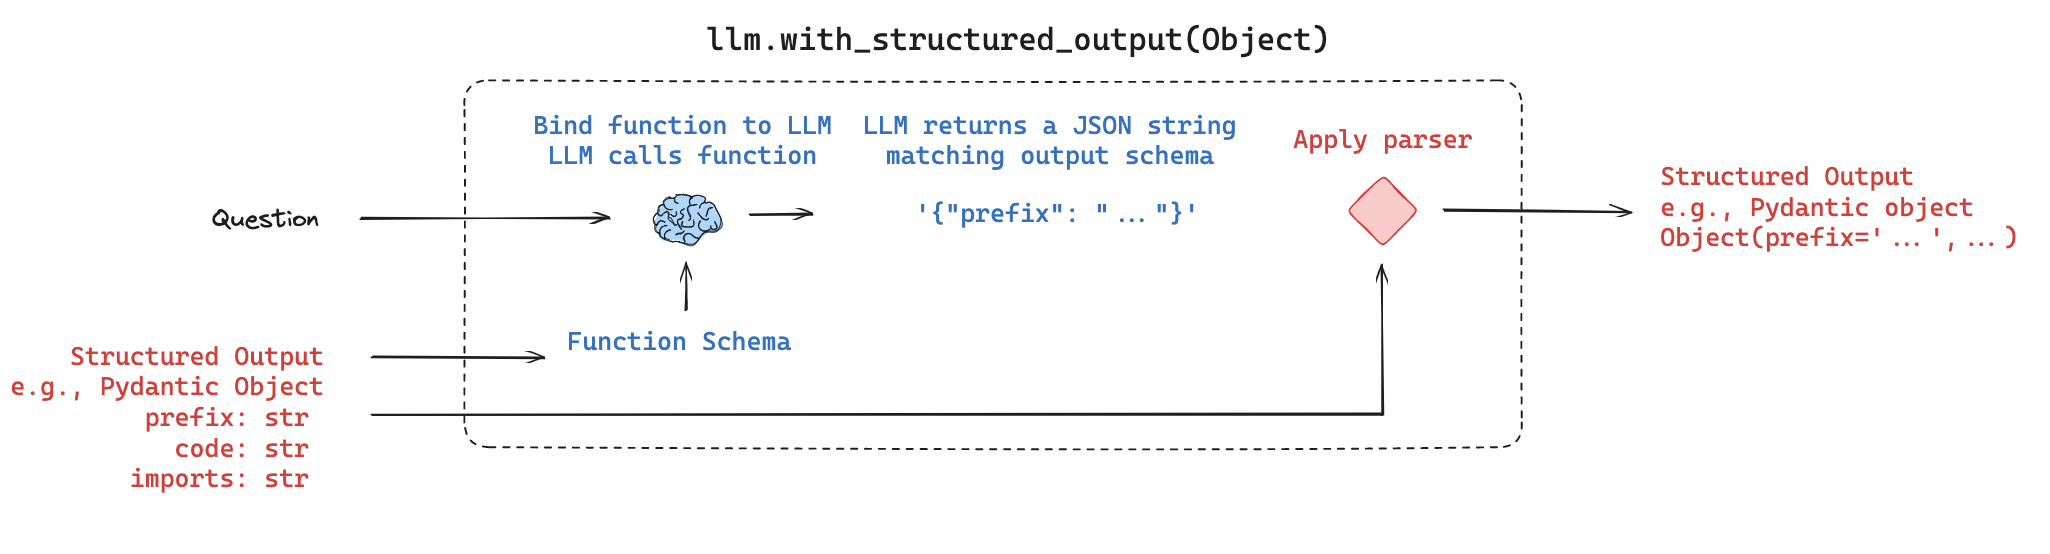

In [ ]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


# LLM
llm = ChatAnthropic(
    model="claude-3-opus-20240229",
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

# Structured output, including raw will capture raw output and parser errors
structured_llm = llm.with_structured_output(code, include_raw=True)
code_output = structured_llm.invoke(
    "Write a python program that prints the string 'hello world' and tell me how it works in a sentence"
)

In [2]:
# Initial reasoning stage
code_output["raw"].content[0]

{'text': "<thinking>\nThe tool 'code' is relevant for writing a Python program to print a string.\n\nTo use the 'code' tool, I need values for these required parameters:\nprefix: A description of the problem and approach. I can provide this based on the request.\nimports: The import statements needed for the code. For this simple program, no imports are needed, so I can leave this blank.\ncode: The actual Python code, not including imports. I can write a simple print statement to output the string.\n\nI have all the required parameters, so I can proceed with calling the 'code' tool.\n</thinking>",
 'type': 'text'}

In [3]:
# Tool call
code_output["raw"].content[1]

{'text': None,
 'type': 'tool_use',
 'id': 'toolu_01UwZVQub6vL36wiBww6CU7a',
 'name': 'code',
 'input': {'prefix': "To print the string 'hello world' in Python:",
  'imports': '',
  'code': "print('hello world')"}}

In [4]:
# JSON str
code_output["raw"].content[1]["input"]

{'prefix': "To print the string 'hello world' in Python:",
 'imports': '',
 'code': "print('hello world')"}

In [5]:
# Error
error = code_output["parsing_error"]
error

In [6]:
# Result
parsed_result = code_output["parsed"]

In [7]:
parsed_result.prefix

"To print the string 'hello world' in Python:"

In [8]:
parsed_result.imports

''

In [9]:
parsed_result.code

"print('hello world')"

## More challenging example

Motivating example for tool use / structured outputs.

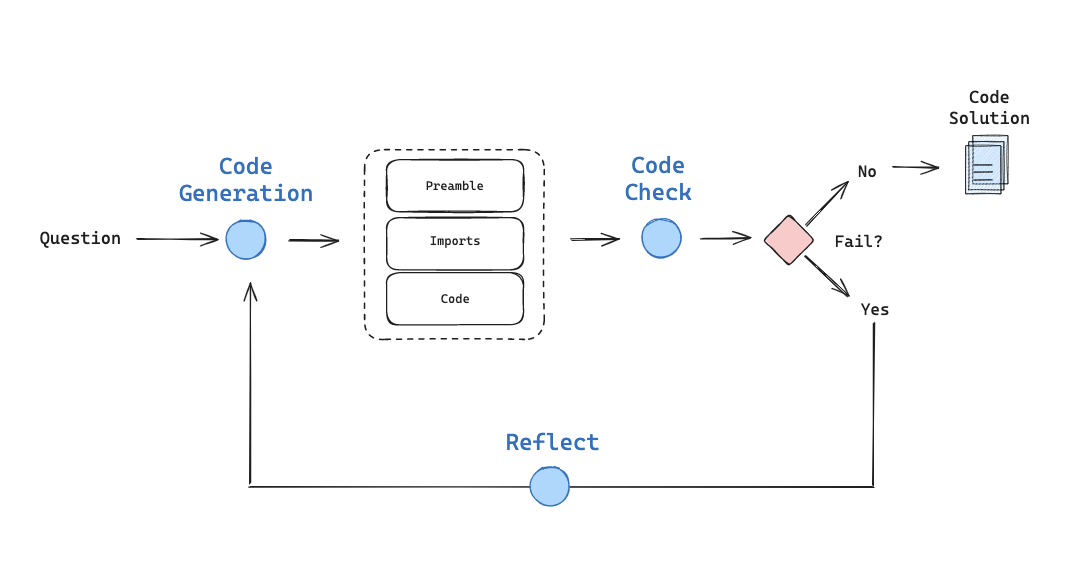

Here are some docs that we want to answer code questions about.

In [10]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

Problem:

`What if we want to enforce tool use?`

We can use fallbacks.

Let's select a code gen prompt that -- from some of my testing -- does not correctly invoke the tool.

We can see if we can correct from this.

In [12]:
# This code gen prompt invokes tool use
code_gen_prompt_working = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# This code gen prompt does not invoke tool use
code_gen_prompt_bad = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


# LLM
llm = ChatAnthropic(
    model="claude-3-opus-20240229",
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

# Structured output
# Include raw will capture raw output and parser errors
structured_llm = llm.with_structured_output(code, include_raw=True)


# Check for errors
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(code_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output


# Chain with output check
code_chain = code_gen_prompt_bad | structured_llm | check_claude_output

Let's add a check and re-try.

In [13]:
def insert_errors(inputs):
    """Insert errors in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "user",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }


# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain
N = 3  # Max re-tries
code_chain_re_try = code_chain.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)

In [14]:
# Test
messages = [("user", "How do I build a RAG chain in LCEL?")]
code_output_lcel = code_chain_re_try.invoke(
    {"context": concatenated_content, "messages": messages}
)

Failed to invoke tool!


In [15]:
parsed_result_lcel = code_output_lcel["parsed"]

In [16]:
parsed_result_lcel.prefix

"To build a RAG chain using LCEL, we'll use a vector store to retrieve relevant documents, a prompt template that incorporates the retrieved context, a chat model (like OpenAI) to generate a response based on the prompt, and an output parser to clean up the model output."

In [17]:
parsed_result_lcel.imports

'from langchain_community.vectorstores import DocArrayInMemorySearch\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_core.runnables import RunnablePassthrough\nfrom langchain_openai import ChatOpenAI, OpenAIEmbeddings'

In [18]:
parsed_result_lcel.code

'vectorstore = DocArrayInMemorySearch.from_texts(\n    ["harrison worked at kensho", "bears like to eat honey"], \n    embedding=OpenAIEmbeddings(),\n)\n\nretriever = vectorstore.as_retriever()\n\ntemplate = """Answer the question based only on the following context:\n{context}\nQuestion: {question}"""\nprompt = ChatPromptTemplate.from_template(template)\n\noutput_parser = StrOutputParser()\n\nrag_chain = (\n    {"context": retriever, "question": RunnablePassthrough()} \n    | prompt \n    | ChatOpenAI()\n    | output_parser\n)\n\nprint(rag_chain.invoke("where did harrison work?"))'

Example trace catching an error and correcting:

https://smith.langchain.com/public/f06e62cb-2fac-46ae-80cd-0470b3155eae/r